In [1]:
DATA_PATH = "./data/"
OUTPUT_PATH = "./out/"

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import numpy as np
import sklearn.ensemble 

from sklearn.externals import joblib

colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())

pxToMm= 0.19

In [3]:
dfStim = pd.read_pickle(DATA_PATH  + "data_03_stim.pkl")

In [4]:
dfStim["RelativeTimePeak"] = dfStim.TimeRelativ -dfStim.TimePeak
TouchEventId = dfStim.groupby(["TouchId"])["TouchEventId"].max().values
dfStim = dfStim[dfStim.TouchEventId.isin(TouchEventId)]
dfStim.TouchOffset.describe()

count    8975.000000
mean       46.565642
std        32.146447
min         0.000000
25%        22.658822
50%        38.964157
75%        62.118346
max       180.249827
Name: TouchOffset, dtype: float64

In [5]:
sorted(dfStim.VisualStimuliPositionY.unique())

[95.0, 731.5, 1368.0, 2004.5, 2641.0]

In [6]:
%%time
dfX = dfStim[dfStim.IsBumpVirtual == 1].copy()
#dfX = dfStim.copy()

dfX["TouchXReal"] = (dfX.TouchX-dfX.VisualStimuliPositionX)*pxToMm
dfX["TouchYReal"] = (dfX.TouchY-dfX.VisualStimuliPositionY)*pxToMm
lendf = len(dfX)
area = np.infty
x2 = -1
y2 = -1
c = 0
for x1 in np.arange(30,40,.1):
    for y1 in np.arange(30,40,.1):
        if ((x1*y1) < area):
            c=c+1
            xx= dfX[((dfX.TouchXReal > (-x1)/2.0) & (dfX.TouchXReal < (x1)/2.0) & (dfX.TouchXReal > (-y1)/2.0) & (dfX.TouchYReal < (y1)/2.0))]
            value = len(xx) / lendf

            if (value > 0.95):
                x2 = x1
                y2 = y1
                area = x1*y1 
print(x2, y2, area)   

36.10000000000009 34.20000000000006 1234.6200000000051
CPU times: user 14.1 s, sys: 11.6 ms, total: 14.1 s
Wall time: 14.1 s


In [7]:
split = (65, 22, 22)
ps = np.array(sorted(dfStim.PId.unique()))
num_pt = len(ps)
x1 = (int)(np.floor(len(ps) * split[1] / 100.0))
x2 = (int)(np.floor(len(ps) * split[2] / 100.0))
split_train = ps[x2+x1:]
split_test = ps[x1:x1+x2]
split_validation = ps[:x2]

dfTrain = dfStim[dfStim.PId.isin(split_train) & (dfStim.VisualStimuliPositionX != sorted(dfStim.VisualStimuliPositionX.unique())[2])& (dfStim.VisualStimuliPositionY != sorted(dfStim.VisualStimuliPositionY.unique())[2])]
dfTest = dfStim[dfStim.PId.isin(split_test)]
dfValidation = dfStim[dfStim.PId.isin(split_validation)]
print("Participants in the validation data set %s" % split_validation)
print("Participants in the       test data set %s" % split_test)
print("Participants in the      train data set %s" % split_train)

Participants in the validation data set [1 3 5]
Participants in the       test data set [6 7 8]
Participants in the      train data set [ 9 10 11 12 13 14 15 16 17 18]


In [8]:
modelX = joblib.load('%s/Model_RF_%s.pkl' % (OUTPUT_PATH, "X"))
modelY = joblib.load('%s/Model_RF_%s.pkl' % (OUTPUT_PATH, "Y"))

In [9]:
dfStim["TouchOffsetXPred"] = modelX.predict(dfStim[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', "PeakValue"]].values)
dfStim["TouchOffsetYPred"] = modelY.predict(dfStim[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', "PeakValue"]].values)

In [10]:
split = (65, 22, 22)
ps = np.array(sorted(dfStim.PId.unique()))
num_pt = len(ps)
x1 = (int)(np.floor(len(ps) * split[1] / 100.0))
x2 = (int)(np.floor(len(ps) * split[2] / 100.0))
split_train = ps[x2+x1:]
split_test = ps[x1:x1+x2]
split_validation = ps[:x2]

dfTrain = dfStim[dfStim.PId.isin(split_train) & (dfStim.VisualStimuliPositionX != sorted(dfStim.VisualStimuliPositionX.unique())[2])& (dfStim.VisualStimuliPositionY != sorted(dfStim.VisualStimuliPositionY.unique())[2])]
dfTest = dfStim[dfStim.PId.isin(split_test)]
dfValidation = dfStim[dfStim.PId.isin(split_validation)]
print("Participants in the validation data set %s" % split_validation)
print("Participants in the       test data set %s" % split_test)
print("Participants in the      train data set %s" % split_train)


Participants in the validation data set [1 3 5]
Participants in the       test data set [6 7 8]
Participants in the      train data set [ 9 10 11 12 13 14 15 16 17 18]


22.91399999999992
25.177435897435863
17.64466666666675
18.489679487179494


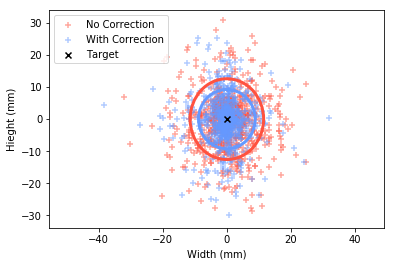

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
colors2 = [colorDic["red"],colorDic["blue"]]
for b in range(2):
    dfX = dfValidation[(dfValidation.IsBumpVirtual == 1)]
    if (b == 1):
        label = "With Correction"
        x = (dfX.TouchX-dfX.VisualStimuliPositionX-dfX["TouchOffsetXPred"] )*pxToMm
        y = (dfX.TouchY-dfX.VisualStimuliPositionY-dfX["TouchOffsetYPred"] )*pxToMm
    else:
        label = "No Correction"
        x = (dfX.TouchX-dfX.VisualStimuliPositionX)*pxToMm
        y = (dfX.TouchY-dfX.VisualStimuliPositionY)*pxToMm
        
    plt.scatter(x, y, marker="+", color=colors2[b], label=label, alpha=0.5)
            
plt.xlabel("Width (mm)")
plt.ylabel("Hieght (mm)")
plt.scatter(0,0, marker="x", color="k", label="Target")

x = (dfX.TouchX-dfX.VisualStimuliPositionX)*pxToMm
y = (dfX.TouchY-dfX.VisualStimuliPositionY)*pxToMm
df5 = dfX.copy()
df5["OffsetCorrected"] = np.sqrt(x*x+y*y)
df5 = df5[df5.OffsetCorrected < np.max(sorted(np.sqrt(x*x+y*y))[:int(np.round(len(dfX)*0.95))])]
x = (df5.TouchX-df5.VisualStimuliPositionX-df5["TouchOffsetXPred"] )*pxToMm
y = (df5.TouchY-df5.VisualStimuliPositionY-df5["TouchOffsetYPred"] )*pxToMm

print(x.abs().max())
print(y.abs().max())
ax.add_artist(Ellipse(xy=(0,0), width=x.abs().max(), height=y.abs().max(), fill=None, color=colors2[0], lw=3))

x = (dfX.TouchX-dfX.VisualStimuliPositionX-dfX["TouchOffsetXPred"] )*pxToMm
y = (dfX.TouchY-dfX.VisualStimuliPositionY-dfX["TouchOffsetYPred"] )*pxToMm
dfX = dfX.copy()
dfX["OffsetCorrected"] = np.sqrt(x*x+y*y)
df6 = dfX[dfX.OffsetCorrected < np.max(sorted(np.sqrt(x*x+y*y))[:int(np.round(len(dfX)*0.95))])]
x = (df6.TouchX-df6.VisualStimuliPositionX-df6["TouchOffsetXPred"] )*pxToMm
y = (df6.TouchY-df6.VisualStimuliPositionY-df6["TouchOffsetYPred"] )*pxToMm
ax.add_artist(Ellipse(xy=(0,0), width=x.abs().max(), height=y.abs().max(), fill=None, color=colors2[1], lw=3))
print(x.abs().max())
print(y.abs().max())

ax.set_aspect('equal', 'datalim')
plt.legend(loc=2)
plt.savefig(OUTPUT_PATH + "corrected.pdf", bbox_inches='tight', pad_inches=0, tranparent = False)